# Model Experiments

In [3]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [28]:
conn = sqlite3.connect('/Users/eerichmo/Documents/fires.sqlite')
cur = conn.cursor()

df_raw = pd.read_sql_query("""
select
	weather_geo.long,
	weather_geo.lat,
	weather_geo.month,
	weather_geo.date,
	weather_geo.precipitation,
	weather_geo.pressure,
	weather_geo.humidity_2m,
	weather_geo.temp_2m,
	weather_geo.temp_dew_point_2m,
	weather_geo.temp_wet_bulb_2m,
	weather_geo.temp_max_2m,
	weather_geo.temp_min_2m,
	weather_geo.temp_range_2m,
	weather_geo.temp_0m,
	weather_geo.wind_10m,
	weather_geo.wind_max_10m,
	weather_geo.wind_min_10m,
	weather_geo.wind_range_10m,
	weather_geo.wind_50m,
	weather_geo.wind_max_50m,
	weather_geo.wind_min_50m,
	weather_geo.wind_range_50m,
	weather_geo.drought_score,
	soil.elevation,
	soil.slope_005,
	soil.slope_005_02,
	soil.slope_02_05,
	soil.slope_05_10,
	soil.slope_10_15,
	soil.slope_15_30,
	soil.slope_30_45,
	soil.slope_45,
	soil.aspect_north,
	soil.aspect_east,
	soil.aspect_south,
	soil.aspect_west,
	soil.aspect_unknown,
	soil.water_land,
	soil.barren_land,
	soil.urban_land,
	soil.grass_land,
	soil.forest_land,
	soil.partial_cultivated_land,
	soil.irrigated_land,
	soil.cultivated_land,
	soil.nutrient,
	soil.nutrient_retention,
	soil.rooting,
	soil.oxygen,
	soil.excess_salts,
	soil.toxicity,
	soil.workablity,
	ifnull(fires.prior_fire_0_1_year, 0) as prior_fire_0_1_year,
	ifnull(fires.prior_fire_1_2_year, 0) as prior_fire_1_2_year,
	ifnull(fires.prior_fire_2_3_year, 0) as prior_fire_2_3_year,
	ifnull(fires.prior_fire_3_4_year, 0) as prior_fire_3_4_year,
	ifnull(fires.prior_fire_4_5_year, 0) as prior_fire_4_5_year,

  ifnull(fires.fire_size_class, '') as fire_size_class
from weather_geo
inner join soil
  on soil.fips = weather_geo.fips
left outer join (
	select
		date,
		long,
		lat,
		max(fire_size_class) as fire_size_class,
		max(prior_fire_0_1_year) as prior_fire_0_1_year,
		max(prior_fire_1_2_year) as prior_fire_1_2_year,
		max(prior_fire_2_3_year) as prior_fire_2_3_year,
		max(prior_fire_3_4_year) as prior_fire_3_4_year,
		max(prior_fire_4_5_year) as prior_fire_4_5_year
	from (
		-- Join date and 1, 2 and 3 days earlier in case the discovery date is delayed
		select date, long, lat, fire_size_class, prior_fire_0_1_year, prior_fire_1_2_year, prior_fire_2_3_year, prior_fire_3_4_year, prior_fire_4_5_year
		from fires
		where cause in ('Other causes', 'Natural', 'Power', 'Recreation')
		union
		select date_1d_before as date, long, lat, fire_size_class, prior_fire_0_1_year, prior_fire_1_2_year, prior_fire_2_3_year, prior_fire_3_4_year, prior_fire_4_5_year
		from fires
		where cause in ('Other causes', 'Natural', 'Power', 'Recreation')
		union
		select date_2d_before as date, long, lat, fire_size_class, prior_fire_0_1_year, prior_fire_1_2_year, prior_fire_2_3_year, prior_fire_3_4_year, prior_fire_4_5_year
		from fires
		where cause in ('Other causes', 'Natural', 'Power', 'Recreation')
		union
		select date_3d_before as date, long, lat, fire_size_class, prior_fire_0_1_year, prior_fire_1_2_year, prior_fire_2_3_year, prior_fire_3_4_year, prior_fire_4_5_year
		from fires
		where cause in ('Other causes', 'Natural', 'Power', 'Recreation')
	) as fires
	where date >= '2008-01-01' and date < '2010-01-01'
	group by date, long, lat
) as fires on
  fires.date = weather_geo.date
  and fires.long = weather_geo.long
  and fires.lat = weather_geo.lat
where
	weather_geo.date >= '2008-01-01'
	and weather_geo.date < '2010-01-01'
	and weather_geo.day in (1, 6, 11, 16, 21, 26)
""", conn)

conn.close()

df_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
long,488308.0,-119.622380,2.509247,-124.25,-121.500000,-120.000000,-117.500000,-114.250000
lat,488308.0,37.251871,2.573237,32.75,35.000000,37.000000,39.500000,42.000000
month,488308.0,6.519836,3.449554,1.00,4.000000,7.000000,10.000000,12.000000
precipitation,488308.0,1.169126,4.697552,0.00,0.000000,0.000000,0.070000,100.570000
pressure,488308.0,91.817253,6.473178,72.18,87.740000,92.660000,97.020000,102.950000
humidity_2m,488308.0,4.975515,1.929029,0.55,3.540000,4.760000,6.160000,18.130000
temp_2m,488308.0,14.294287,9.432666,-16.37,7.510000,13.650000,21.400000,39.500000
temp_dew_point_2m,488308.0,1.386731,6.012727,-22.60,-2.740000,1.770000,5.790000,23.120000
temp_wet_bulb_2m,488308.0,7.840504,6.605227,-17.52,3.350000,8.070000,12.750000,27.440000
temp_max_2m,488308.0,21.764659,10.936759,-12.18,13.680000,21.340000,30.550000,48.120000


In [15]:
final = df_raw.isna().sum()
cols = []
for count, col in zip(final,list(df_raw.columns)):
    if count > 0:
        cols.append(col)

print(f'Columns with null: {cols}')

Columns with null: []


In [29]:
df_fire_false = df_raw[df_raw.fire_size_class == '']
df_fire_true = df_raw[df_raw.fire_size_class != '']
print(f'Unbalanced classes of NO fire: {len(df_fire_false):,} and YES fire: {len(df_fire_true):,}')

df_fire_true_balanced = df_fire_true.sample(n=len(df_fire_false), replace=True)

df_fires = pd.concat([df_fire_false, df_fire_true_balanced], axis=0)
df_fire_false = df_fires[df_fires.fire_size_class == '']
df_fire_true = df_fires[df_fires.fire_size_class != '']
print(f'Balanced classes of NO fires: {len(df_fire_false):,} and YES fire: {len(df_fire_true):,}')

X_trim = df_fires.drop(['date', 'fire_size_class'], axis=1)

Unbalanced classes of NO fire: 480,959 and YES fire: 7,349
Balanced classes of NO fires: 480,959 and YES fire: 480,959


In [30]:
X_encoded = pd.get_dummies(X_trim, columns=['month'])

scaler = StandardScaler()
scaler.fit(X_encoded)
X = scaler.transform(X_encoded)

### All Fire Sizes (A-G)

In [31]:
y = (df_fires.fire_size_class != '').values

num_fires = (y == 1).sum()
num_data_pt = len(y)
print(f'{num_fires} fires out of {len(y)} data points')
print(f'No fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie Balanced)')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

params={
  'C': [0.1],
}

log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg = GridSearchCV(estimator=log_reg, param_grid=params, scoring='recall', cv=5)

log_reg.fit(X_train, y_train)

print(f'All size fires estimator', log_reg.best_estimator_)

480959 fires out of 961918 data points
No fires 50.0% of the time (ie Balanced)


In [25]:
y_pred_log_reg = log_reg.predict(X_train)

print('--------- Log Regression Classification ---------')
print(classification_report(y_train, y_pred_log_reg))

--------- Log Regression Classification ---------
              precision    recall  f1-score   support

       False       0.81      0.76      0.78     71012
        True       0.78      0.82      0.80     71101

    accuracy                           0.79    142113
   macro avg       0.79      0.79      0.79    142113
weighted avg       0.79      0.79      0.79    142113



In [9]:
from sklearn.ensemble import RandomForestClassifier

params = {
  'n_estimators': np.arange(40, 100, 20),
  # 'splitter': ['best', 'random'],
  'max_features': np.arange(4, 12, 1),
  'max_depth': np.arange(10, 20, 2),
  'min_samples_split': np.arange(4, 12, 2),
  'min_samples_leaf': np.arange(2, 10, 2),
  'max_leaf_nodes': np.arange(4, 10, 2),
}

rand_forest = RandomizedSearchCV(RandomForestClassifier(), params, scoring="recall")
rand_forest.fit(X_train, y_train)

print(f'Best Params', rand_forest.best_params_)

print('--------- RandomForestClassifier Classification ---------')
y_pred_rand_forest = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred_rand_forest))

Best Params {'n_estimators': 40, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_leaf_nodes': 8, 'max_features': 9, 'max_depth': 16}
Best Score 0.7684278282225012
--------- RandomForestClassifier Classification ---------
              precision    recall  f1-score   support

       False       0.76      0.79      0.78    120294
        True       0.78      0.75      0.77    120186

    accuracy                           0.77    240480
   macro avg       0.77      0.77      0.77    240480
weighted avg       0.77      0.77      0.77    240480



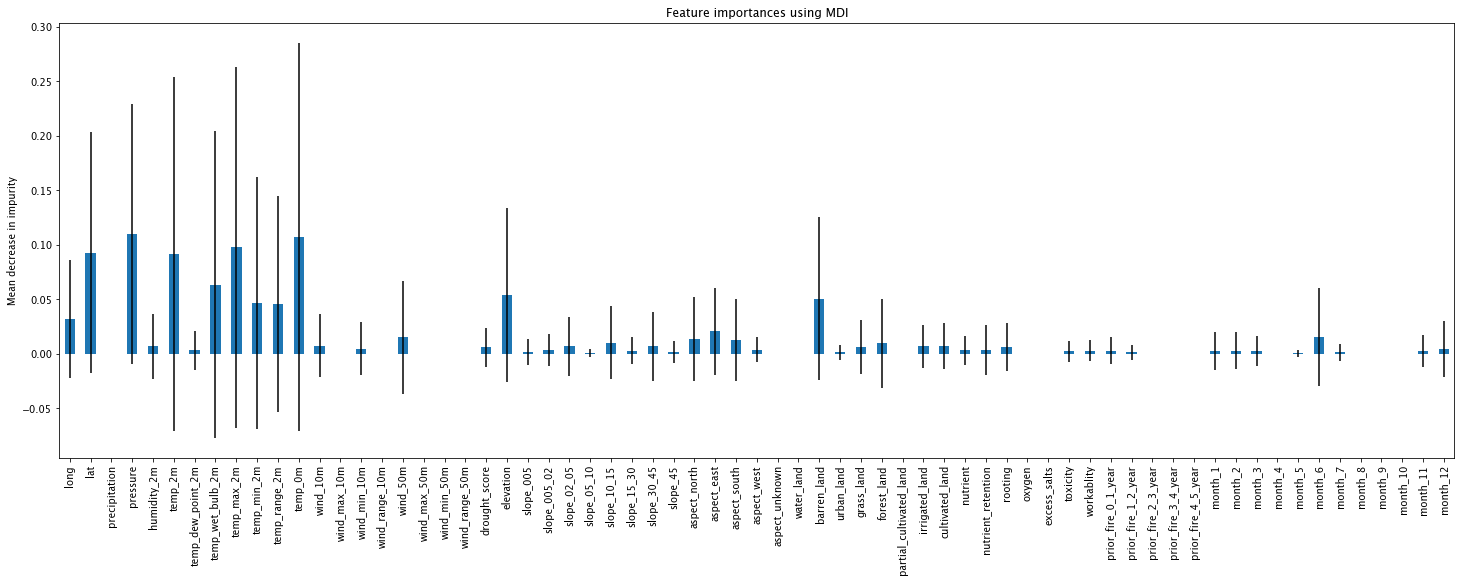

In [10]:
importances = rand_forest.best_estimator_.feature_importances_
forest_importances = pd.Series(importances, index=X_encoded.columns.values)
std = np.std([tree.feature_importances_ for tree in rand_forest.best_estimator_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.set_figheight(8)
fig.set_figwidth(25)

In [11]:
import xgboost as xgb

params={
  'objective': ['binary:logistic'],
  'max_depth': [5],
  'gamma':[0.5],
  'subsample': [0.5],
  'colsample_bytree': [0.1],
  'colsample_bylevel': [1.0],
  'learning_rate': [0.1],
  'n_estimators': [600],
  'eval_metric': ['logloss']
}

xgb_clf = xgb.XGBClassifier(seed=42, use_label_encoder=False)

xgb_clf = GridSearchCV(estimator=xgb_clf, param_grid=params)

xgb_clf.fit(X_train, y_train)

print("Best Params:", xgb_clf.best_params_)

Best Params: {'colsample_bylevel': 1.0, 'colsample_bytree': 0.1, 'eval_metric': 'logloss', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 600, 'objective': 'binary:logistic', 'subsample': 0.5}


In [12]:
y_pred_xgb = xgb_clf.predict(X_test)

print('--------- XGBoost Classification Report ---------')
print(classification_report(y_test, y_pred_xgb))

--------- XGBoost Classification Report ---------
              precision    recall  f1-score   support

       False       0.96      0.85      0.90    120294
        True       0.87      0.96      0.91    120186

    accuracy                           0.91    240480
   macro avg       0.91      0.91      0.91    240480
weighted avg       0.91      0.91      0.91    240480



### Only Larger Fire Sizes (10-5000+ arces)

A=0-0.25 acres, B=0.26-9.9 acres, C=10.0-99.9 acres, D=100-299 acres, E=300 to 999 acres, F=1000 to 4999 acres, and G=5000+ acres

In [ ]:
df_non_small_false = df_raw[df_raw.fire_size_class < 'C']
df_non_small_true = df_raw[df_raw.fire_size_class >= 'C']
print(f'Unbalanced classes of NO fire: {len(df_non_small_false):,} and YES fire: {len(df_non_small_true):,}')

df_non_small_true_balanced = df_non_small_true.sample(n=len(df_non_small_false), replace=True)

df_non_small = pd.concat([df_non_small_false, df_non_small_true_balanced], axis=0)
df_non_small_false = df_non_small[df_non_small.fire_size_class < 'C']
df_non_small_true = df_non_small[df_non_small.fire_size_class >= 'C']
print(f'Balanced classes of NO fires: {len(df_non_small_false):,} and YES fire: {len(df_non_small_true):,}')

X_non_small_trim = df_non_small.drop(['date', 'fire_size_class'], axis=1)

X_non_small_encoded = pd.get_dummies(X_non_small_trim, columns=['month'])

scaler = StandardScaler()
scaler.fit(X_non_small_encoded)
X_non_small = scaler.transform(X_non_small_encoded)

Unbalanced classes of NO fire: 96,020 and YES fire: 172
Balanced classes of NO fires: 96,020 and YES fire: 96,020


In [ ]:
y_non_small = (df_non_small.fire_size_class >= 'C').values # Ignore small fires ('', 'A', 'B') for now

X_non_small_train, X_non_small_test, y_non_small_train, y_non_small_test = train_test_split(X_non_small, y_non_small, random_state=42)

params={
  'C': [0.1],
}

log_reg_non_small = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg_non_small = GridSearchCV(estimator=log_reg_non_small, param_grid=params, scoring='recall', cv=5)

log_reg_non_small.fit(X_non_small_train, y_non_small_train)

print(f'10+ acre fires estimator', log_reg_non_small.best_estimator_)

10+ acre fires estimator LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')


In [16]:
print('--------- Log Regression Accuracy (10+ arce fires) ---------')
print(accuracy_score(log_reg_non_small.predict(X_non_small_test), y_non_small_test))

y_non_small_pred_log_reg = log_reg_non_small.predict(X_non_small_train)

print('--------- Log Regression Classification (10+ acre fires) ---------')
print(classification_report(y_non_small_train, y_non_small_pred_log_reg))

--------- Log Regression Accuracy (10+ arce fires) ---------
0.8475352329374115
--------- Log Regression Classification (10+ acre fires) ---------
              precision    recall  f1-score   support

       False       0.87      0.82      0.84    365390
        True       0.83      0.87      0.85    365813

    accuracy                           0.85    731203
   macro avg       0.85      0.85      0.85    731203
weighted avg       0.85      0.85      0.85    731203



In [17]:
import xgboost as xgb

params={
  'objective': ['binary:logistic'],
  'max_depth': [3],
  'gamma':[5],
  'subsample': [0.5],
  'colsample_bytree': [0.1],
  'colsample_bylevel': [1.0],
  'learning_rate': [0.1],
  'n_estimators': [500],
  'eval_metric': ['logloss']
}

xgb_clf_non_small = xgb.XGBClassifier(seed=42, use_label_encoder=False)

xgb_clf_non_small = GridSearchCV(estimator=xgb_clf_non_small, param_grid=params)

xgb_clf_non_small.fit(X_non_small_train, y_non_small_train)

print("10+ acre best Params:", xgb_clf_non_small.best_params_)

10+ acre best Params: {'colsample_bylevel': 1.0, 'colsample_bytree': 0.1, 'eval_metric': 'logloss', 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'subsample': 0.5}


In [ ]:
y_non_small_pred_xgb = xgb_clf_non_small.predict(X_non_small_test)

print('--------- XGBoost Classification Report (10+ acre fires) ---------')
print(classification_report(y_non_small_test, y_non_small_pred_xgb))

--------- XGBoost Classification Report (non-small) ---------
              precision    recall  f1-score   support

       False       0.83      0.78      0.80     16677
        True       0.79      0.84      0.81     16670

    accuracy                           0.81     33347
   macro avg       0.81      0.81      0.81     33347
weighted avg       0.81      0.81      0.81     33347

